# CU4 Simulation Data Exploration

- Data exploration
- Simple data visualization
- PCA for feature extraction on one experiment
- Visualizing PCA results
- Concatenating and normalizing the data
- PCA for feature extraction on entire dataset
- PCA for feature selection on one experiment
- PCA for feature selection on entire dataset
- Saving data for future reference

### Data Exploration

First, it is necessary to import the relevant libraries and to store the data.

In [1]:
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np
from numpy.linalg import eigh
import OpenMORe.OpenMORe.model_order_reduction as model_order_reduction
from OpenMORe.OpenMORe.utilities import *
import matplotlib

In [2]:
path = os.getcwd() + "/CU4/"
csv_files = glob.glob(os.path.join(path, "*.csv"))

cu4 = []

for filename in csv_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    cu4.append(df)

Let's explore the shape of the data. There are 20 trials. For each trial, 512 data points were taken, each encapsulating 5 variables (x, eta, u, v, and pressure).

In [3]:
print("Number of trials: " + str(len(cu4)))
print("Data dimension for each trial: " + str(cu4[0].shape))
print("Variables measured: " + str(cu4[0].columns.values))

Number of trials: 20
Data dimension for each trial: (512, 5)
Variables measured: ['x' 'eta' 'u' 'v' 'pressure']


Here are summary statistics for each of the variables in the first trial.

In [4]:
cu4_pd = pd.DataFrame(cu4[0])

cu4_pd.describe().transpose()

count          mean       std       min       25%       50%  \
x         512.0 -2.220446e-16  1.819123 -3.141590 -1.570795  0.000000   
eta       512.0  1.763672e-05  0.036570 -0.046550 -0.036005 -0.005960   
u         512.0  2.634265e+00  0.147801  2.326230  2.564970  2.624630   
v         512.0  4.338672e-04  0.117397 -0.203350 -0.113547 -0.000610   
pressure  512.0  5.497930e-05  0.000409 -0.000809 -0.000288  0.000044   

               75%       max  
x         1.570795  3.141590  
eta       0.034930  0.058560  
u         2.709000  2.962210  
v         0.114022  0.183560  
pressure  0.000405  0.000765

### Simple Data Visualization

Next, we will explore the data by plotting it. We will only examine one experiment for simplicity. The first plot illustrates that the waves are uniform, meaning that they have a regular periodicity and a consistent amplitude.

<AxesSubplot:xlabel='x'>

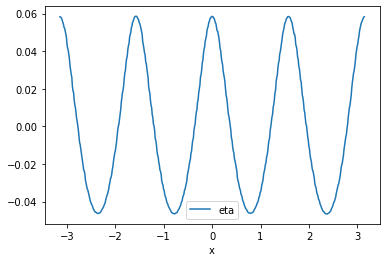

In [5]:
cu4_sub = cu4[0]

cu4_sub.plot.line(x="x", y="eta")

This plot maps the component of the wind along the x axis. You may observe that the wind slows down and speeds up as it passes over the waves, but its direction is consistent (u is always positive).

<AxesSubplot:xlabel='x'>

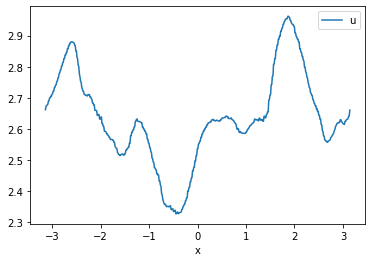

In [5]:
cu4_sub.plot(x="x", y="u")

On the other hand, v represents the direction of the wind in the y direction. In the following plot, you may observe that v takes on both negative and positive directions. Generally speaking, this must mean that the wind rises when the wave rises, and falls when the wave falls.

<AxesSubplot:xlabel='x'>

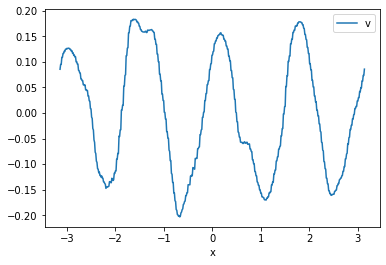

In [6]:
cu4_sub.plot(x="x",y="v")

Pressure is the variable of interest here. We have plotted it against x. Its roughly sinusoidal shape (with variation) indicates that pressure must be corresponded in some way to the wave shape and/or the wind direction. 

<AxesSubplot:xlabel='x'>

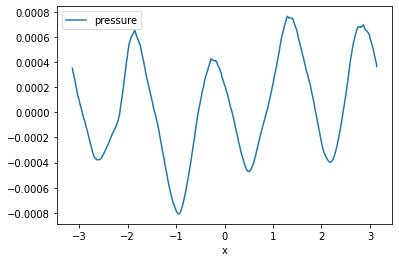

In [7]:
cu4_sub.plot(x="x",y="pressure")

The following plot illustrates all of the data together. Note that some of the variables have different scales from one another. Here, pressure looks constant, even though we just observed that it is roughly sinusoidal. Also, u takes on larger values than the other variables, which makes the graph harder to understand. In the following graph, all variables are normalized, so that one can observe patterns as they are overlayed.

<AxesSubplot:xlabel='x'>

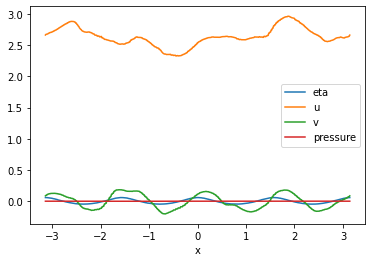

In [45]:
cu4_sub.plot.line(x="x")

The following illustrates the normalized data. The eta, v, and pressure variables seem roughly sinusoidal in shape, with some offset in the x direction from one another. The u variable seems sinusoidal as well, with a period that is twice as long as the other variables. 

<AxesSubplot:xlabel='x'>

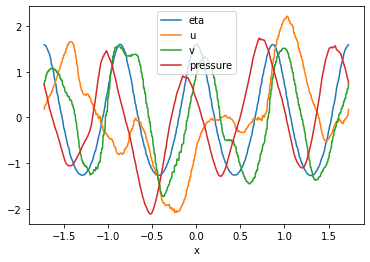

In [17]:
cu4_sub_normalized = (cu4_sub-cu4_sub.mean())/cu4_sub.std()
cu4_sub_normalized.plot.line(x="x")

We will now view the joint distribution of the variables in the dataset.

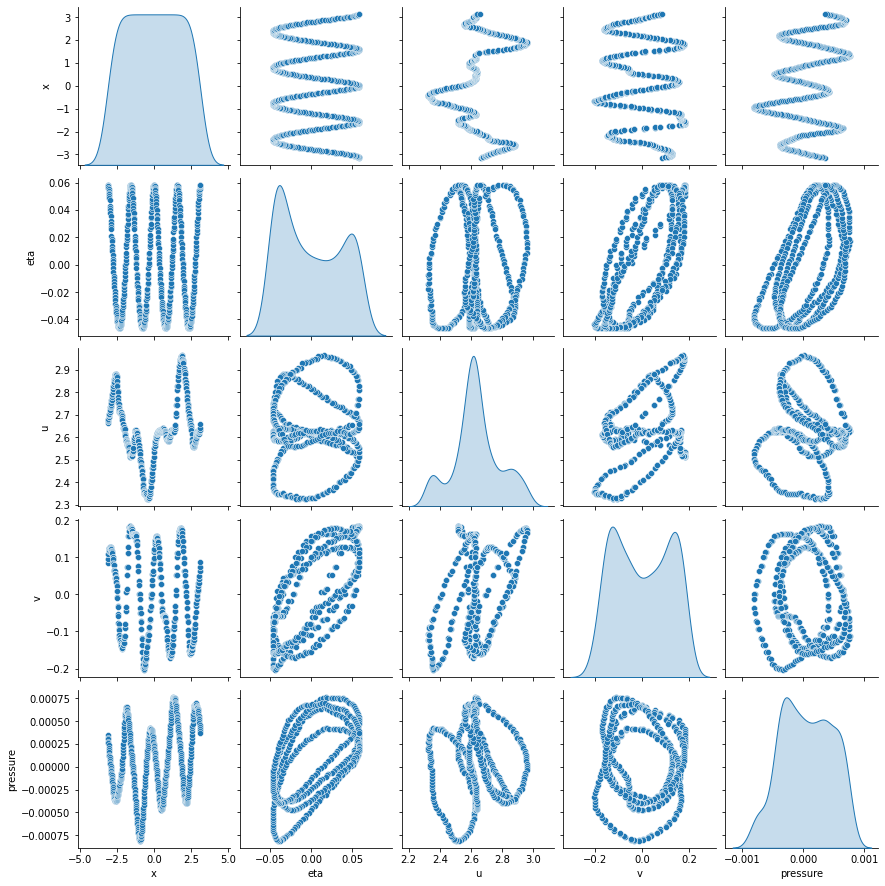

In [9]:
sns.pairplot(cu4_sub[['x', 'eta', 'u', 'v', 'pressure']], diag_kind='kde')

The first row indicates that all other variables may be correlated to x. Notice that many of other variables do not seem highly correlated with one another; if they were, we would be witnessing correlations that resemble functions in the pairplots (not just random circles).

As you obtain more data, how do these relationships change? Do the squiggles go away?

### PCA for Feature Extraction on One Experiment

Principal Component Analysis is essentially just a lossy compression of our data. It aims to find the directions of maximum variance in high-dimensional data and projects the data onto a new subspace with equal or fewer dimensions than the original one. PCA replaces p variables by k < p uncorrelated linear combinations (projections). First, we will run principle component analysis just using the data from one experiment. Then, we will apply the same technique to the larger set of experiments. 

There are multiple reasons why we use PCA. The first is that it will reduce the input dimension of our learning algorithm. This will be especially important as we begin to feed more and more data into the neural network that we build. It also might give interesting results in terms of data visualization. For this notebook, we use PCA for feature extraction. In other words, it will shed light onto which variables best explain the variance of our data set.

It is important to note that we only want to run PCA for feature extraction on the subset of data that does not include pressure. This is because the PCA results are eventually fed into a deep neural network! If the variable we are trying to predict is pressure, we can't feed the network data that has pressure information baked into it!

First, we must remove pressure from the dataset.

In [8]:
cu4_sub = cu4_sub.drop(['pressure'],axis=1)
cu4_sub

x      eta        u        v
0   -3.14159  0.05827  2.66141  0.08565
1   -3.12930  0.05819  2.67244  0.09502
2   -3.11700  0.05785  2.67406  0.09523
3   -3.10471  0.05731  2.67721  0.10888
4   -3.09241  0.05615  2.67877  0.10890
..       ...      ...      ...      ...
507  3.09241  0.05558  2.63117  0.06287
508  3.10471  0.05656  2.63239  0.06217
509  3.11700  0.05733  2.63972  0.07377
510  3.12930  0.05807  2.64065  0.07350
511  3.14159  0.05828  2.66008  0.08590

[512 rows x 4 columns]

First, we must standardize/normalize the dataset.

In [9]:
# Standardize the dataset; This is very important before you apply PCA
sc = StandardScaler()
sc.fit(cu4_sub)
cu4_sub_std = sc.transform(cu4_sub)
cu4_sub_std

array([[-1.72866966,  1.59445558,  0.18383971,  0.72658722],
       [-1.72190705,  1.59226585,  0.25854009,  0.80647963],
       [-1.71513894,  1.58295954,  0.26951149,  0.80827018],
       ...,
       [ 1.71513894,  1.56872635,  0.03694477,  0.62529354],
       [ 1.72190705,  1.58898127,  0.04324317,  0.62299141],
       [ 1.72866966,  1.59472929,  0.17483232,  0.72871883]])

Next, we will construct the covariance matrix. This will be a 5x5 matrix, where each entry corresponds to a pairwise covariance between the different features. A positive covariance means that the features are more positively correlated to one another, and a negative covariance means that the features are more negatively correlated (i.e. when one rises, the other falls).

In [10]:
# Determine covariance matrix
cov_matrix = np.cov(cu4_sub_std, rowvar=False)
cov_matrix

array([[ 1.00195695, -0.00585348,  0.10022562, -0.18239079],
       [-0.00585348,  1.00195695,  0.00787339,  0.70420867],
       [ 0.10022562,  0.00787339,  1.00195695,  0.3785451 ],
       [-0.18239079,  0.70420867,  0.3785451 ,  1.00195695]])

Next, we perform eigendecomposition of the covariance matrix. This decomposes the covariance matrix into its eigenvectors and eigenvalues. Each eigenvector corresponds to a principal component. If you rank the eigenvectors in order of their eigenvalues (biggest to smallest), you discover which principal components explain the most variance in the data (most explanatory to least explanatory).

In [11]:
# Determine eigenvalues and eigenvectors
egnvalues, egnvectors = eigh(cov_matrix)
egnvalues

array([0.174654  , 0.91757204, 1.09857268, 1.81702907])

Sort the eigenvalues by decreasing order to rank the corresponding eigenvectors. Note that var_exp provides us with the amount of information or variance each principal component holds after projecting the data to a lower dimensional subspace.

In [12]:
# Determine explained variance and select the most important eigenvectors based on explained variance
total_egnvalues = sum(egnvalues)
var_exp = [(i/total_egnvalues) for i in sorted(egnvalues, reverse=True)]
var_exp

[0.45337004642578016,
 0.274106756596444,
 0.2289449779191017,
 0.04357821905867417]

This means that principal component 1 holds 45.3% of the information and principal component 2 holds 27.4% of the information, and so on and so forth. If we reduce our data to 2 dimensions, we could say that, during the data reduction, about 26% of the information was lost. It makes sense that we lost a lot of the information during the reduction, since our 4-dimensional data was reduced to a 2-dimensional space.

If you look closely at the explained variance, you may note that 95.6% of the data is explained with 3 newly constructed variables.

### Visualizing PCA Results

We will now run PCA again, this time using the OpenMORe library. The goal is to visualize the ability of PCA to capture the original dataset. First, we will show the variance explained by the principal components. Next, we will show the magnitudes of the eigenvalues (we can expect each subsequent eigenvector to be associated with a smaller eigenvalue than the previous one). Afterwards, we will reconstruct one of our original variables (namely, the u component of the wind velocity) using the principal components. Finally, we will visualize how the original variables contribute to each of the principal components.

We already saw that the first 4 eigenvectors explain about 99% of the variance in the data. Therefore, we will conduct our visualization using those eigenvectors.

D'Alessio et al., "Analysis of turbulent reacting jets via principal component analysis." Data Analysis for Direct Numerical Simulations of Turbulent Combustion. Springer, Cham, 2020. 233-251.

In [13]:
%%bash
cd OpenMORe/
python setup.py install

running install
running build
running build_py
running install_lib
running install_egg_info
Removing /Users/vikimancoridis/opt/anaconda3/lib/python3.9/site-packages/OpenMORe-1.0.0-py3.9.egg-info
Writing /Users/vikimancoridis/opt/anaconda3/lib/python3.9/site-packages/OpenMORe-1.0.0-py3.9.egg-info


In [14]:
# Dictionary with the instruction for the PCA algorithm:
settings ={
    #centering and scaling options
    "center"                    : True,
    "centering_method"          : "mean",
    "scale"                     : True,
    "scaling_method"            : "auto",

    #set the final dimensionality
    "number_of_eigenvectors"    : 3,
    
    #enable to plot the cumulative explained variance
    "enable_plot_variance"      : True,
    
    #set the number of the variable whose reconstruction must be plotted
    "variable_to_plot"          : 2,

}

# Start the dimensionality reduction and the feature extraction step:
# call the PCA class and give in input X and the dictionary with the instructions
model = model_order_reduction.PCA(cu4_sub_std, settings)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


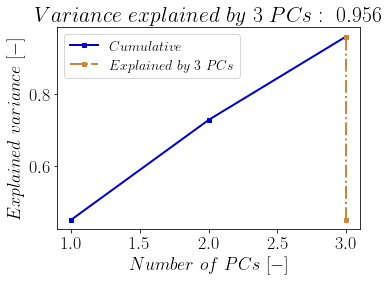

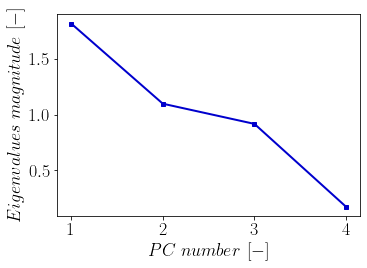

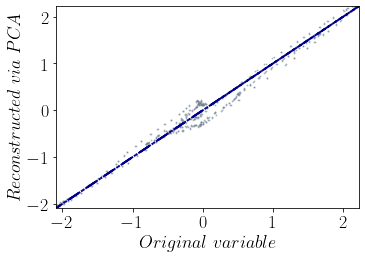

In [134]:
# Perform the dimensionality reduction via Principal Component Analysis,
# and return the eigenvectors of the reduced manifold 
PCs = model.fit()

# Compute the projection of the original points on the reduced
# PCA manifold, obtaining the scores matrix Z
Z = model.get_scores()

# Assess the percentage of explained variance if the number of PCs has not
# been set automatically, and plot the result
model.get_explained()

# Reconstruct the matrix from the reduced PCA manifold
X_recovered = model.recover()

# Compare the reconstructed chosen variable "set_num_to_plot" with the
# original one, by means of a parity plot
model.plot_parity()

Notice that, in the final plot, the original variable (the u component of the wind) is approximately, but not exactly, reconstructed using PCA. If the variable were perfectly constructed with PCA, then the grey dots would lie exactly on the blue line. (As an interseting aside, if you reduce the number of eigenvectors to 3 or even 2, you will see that the variable reconstruction drastically deteriorates). [Would this be something that is compelling to include as a graphic?]

Each eigenvector is a linear combination of the original variables. Therefore, each variable has an associated weight on each principal component. The following plots illustrate the weight of each variable on every principal component. Recall that each subsequent principal component explains less variance for the data than the previous; variables that are heavily weighted in the first few principal components are therefore the most critical in terms of explaining the overall variance in the data.

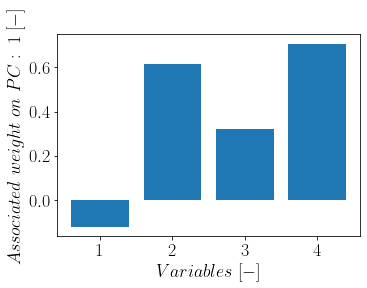

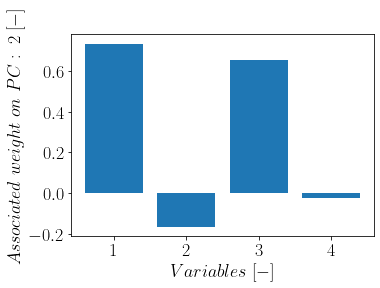

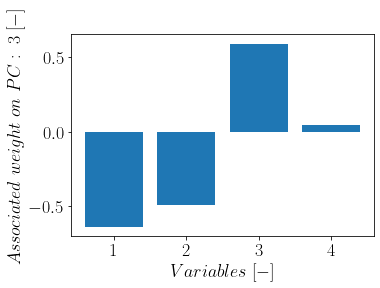

In [117]:
for i in range (0, settings["number_of_eigenvectors"]):
    matplotlib.rcParams.update({'font.size' : 18, 'text.usetex' : True})
    fig = plt.figure()
    axes = fig.add_axes([0.15,0.15,0.7,0.7], frameon=True)
    x = np.linspace(1, cu4_sub_std.shape[1], cu4_sub_std.shape[1])
    axes.bar(x, PCs[0][:,i])
    axes.set_xlabel('$Variables\ [-]$')
    axes.set_ylabel('$Associated\ weight\ on\ PC:\ {}\ [-]$'.format(i + 1))
    plt.show()

Recall that variable 1 is x, variable 2 is eta, variable 3 is u, and variable 4 is v.

We can see that the first variable (x) barely contributes to the first principal component. However, it is one of the most significant contributors to all other principal components. Notice that the second variable (eta) contributes positively to some principal components, but negatively to others. The third variable contributes about the same to each principal component (which is kind of suss? but this variable is not ruled out!!). The fourth variable has a high contribution to the first principal component, but is relatively impactful for the third principal component.

It is critical to note that there are no variables which are relatively unimportant to all of the principal components. In other words, each variable contributes its own unique information to the overall variance.

### Concatenating and  Normalizing the Data

Before, we did PCA with the data of only one trial. We must normalize all of our data to continue to our learning model. The following block of code is taken from this tutorial: https://github.com/mGalarnyk/Python_Tutorials/blob/master/Sklearn/PCA/PCA_to_Speed-up_Machine_Learning_Algorithms.ipynb . Not sure why it works? Shouldn't we just be able to subtract the mean and divide by the standard deviation for all variables?

In [118]:
# Standardize the dataset; This is very important before you apply PCA
cu4_sc = []

for i in range (0, len(cu4)):
    sc = StandardScaler()
    sc.fit(cu4[i])
    cu4_sc.append(sc.transform(cu4[i]))

cu4_nn = np.array(cu4_sc)
cu4_concat = cu4_nn.reshape(cu4_nn.shape[0] * cu4_nn.shape[1], cu4_nn.shape[2])
cu4_concat.shape

(10240, 5)

Again, we will remove the pressure variable (stored at index 4).

In [127]:
cu4_concat = np.delete(cu4_concat, 4, 1)

### PCA for Feature Extraction on Entire Dataset

Now, we will run PCA on the entire dataset, not just one experiment. We will apply the same visualization techniques as seen in the previous section.

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


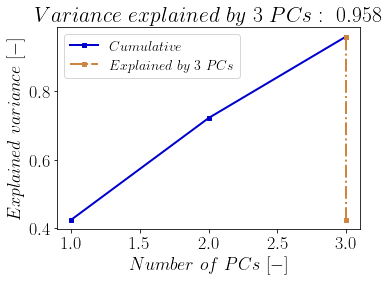

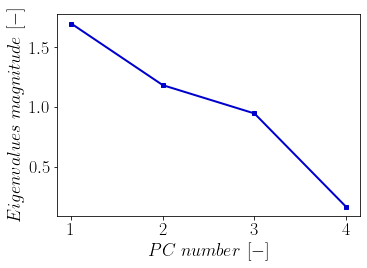

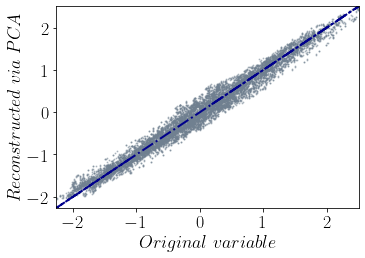

In [140]:
# Dictionary with the instruction for the PCA algorithm:
settings ={
    #centering and scaling options
    "center"                    : True,
    "centering_method"          : "mean",
    "scale"                     : True,
    "scaling_method"            : "auto",

    #set the final dimensionality
    "number_of_eigenvectors"    : 3,
    
    #enable to plot the cumulative explained variance
    "enable_plot_variance"      : True,
    
    #set the number of the variable whose reconstruction must be plotted
    "variable_to_plot"          : 2,

}

# Start the dimensionality reduction and the feature extraction step:
# call the PCA class and give in input X and the dictionary with the instructions
model = model_order_reduction.PCA(cu4_concat, settings)

# Perform the dimensionality reduction via Principal Component Analysis,
# and return the eigenvectors of the reduced manifold 
PCs = model.fit()

# Compute the projection of the original points on the reduced
# PCA manifold, obtaining the scores matrix Z
Z = model.get_scores()

# Assess the percentage of explained variance if the number of PCs has not
# been set automatically, and plot the result
model.get_explained()

# Reconstruct the matrix from the reduced PCA manifold
X_recovered = model.recover()

# Compare the reconstructed chosen variable "set_num_to_plot" with the
# original one, by means of a parity plot
model.plot_parity()

For one experiment, we had that 95.6% of the data was explained with 3 principal components and 72.7% was explained by 2. We have a similar result for all of the concatenated data: 95.8% of the data is explained by 3 principal components and 72.1% was explained by 2. Notice how there are many more datapoints than previously, though.

How do the original variables contribute to the principal components when considering the entire dataset?

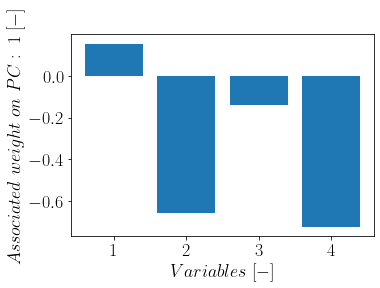

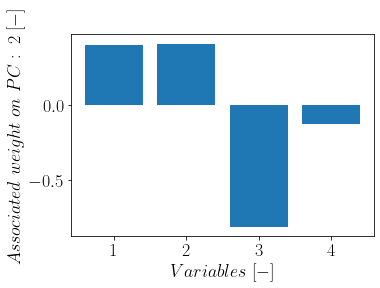

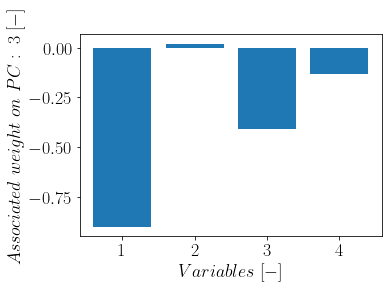

In [141]:
for i in range (0, settings["number_of_eigenvectors"]):
    matplotlib.rcParams.update({'font.size' : 18, 'text.usetex' : True})
    fig = plt.figure()
    axes = fig.add_axes([0.15,0.15,0.7,0.7], frameon=True)
    x = np.linspace(1, cu4_sub_std.shape[1], cu4_sub_std.shape[1])
    axes.bar(x, PCs[0][:,i])
    axes.set_xlabel('$Variables\ [-]$')
    axes.set_ylabel('$Associated\ weight\ on\ PC:\ {}\ [-]$'.format(i + 1))
    plt.show()

Notice how the variables contribute to the principal components in completely different proportions! This is an interesting result, considering that a similar amount of variance is captured by both sets of principal components, relative to the data that they are describing.

Also note that Z is the projection of the original data matrix (centered and scaled) onto the low-dimensional manifold spanned by the first 3 principal components. For a quick verification, check the dimensionality of the original data matrix and Z!

In [143]:
cu4_concat.shape

(10240, 4)

In [144]:
Z.shape

(10240, 3)

### PCA for feature selection on one experiment

We have just performed feature extraction on our data. Now, we will run feature selection. What's the difference? With feature selection, we are going to select a subset of original features (the most important ones) in order to reduce our model's complexity. With feature extraction, we are obtaining information from the original features in order to create a new features subspace, which captures the data's relevant information.

Again, we are referencing the OpenMORe library. Here is the credit:

D'Alessio et al., "Analysis of turbulent reacting jets via principal component analysis." Data Analysis for Direct Numerical Simulations of Turbulent Combustion. Springer, Cham, 2020. 233-251.

First, we specify the analysis.

In [15]:
cu4_sub_std

array([[-1.72866966,  1.59445558,  0.18383971,  0.72658722],
       [-1.72190705,  1.59226585,  0.25854009,  0.80647963],
       [-1.71513894,  1.58295954,  0.26951149,  0.80827018],
       ...,
       [ 1.71513894,  1.56872635,  0.03694477,  0.62529354],
       [ 1.72190705,  1.58898127,  0.04324317,  0.62299141],
       [ 1.72866966,  1.59472929,  0.17483232,  0.72871883]])

In [60]:
# Dictionary with the instructions for PCA feature selection class:
settings = {
    #centering and scaling options
    "center"                    : True,
    "centering_method"          : "mean",
    "scale"                     : True,
    "scaling_method"            : "auto",

    #variables selection options
    "method"                    : "procrustes",
    "number_of_eigenvectors"    : 3,
    "number_of_variables"       : 4
}

Next, we perform feature selection.

In [61]:
PVs = model_order_reduction.variables_selection(cu4_sub_std, settings)
labels, numbers = PVs.fit()
print(labels)

Could not open/read the selected file: not given
Using variables numbers instead of names.
Selecting global variables via PCA and procrustes Analysis...
Current number of variables: 4
[0 2 3 4]


Recall that the labels were: 

- 0: x
- 1: eta
- 2: u
- 3: v
- 4: pressure

Therefore, we see that the feature selection algorithm has omitted the eta variable. In other words, with three eigenvectors, the eta value was the feature out of all original features that explained the variance of the data the least.

### PCA for feature selection on entire dataset

When performing feature selection on the entire dataset, does the algorithm also omit the eta feature? Let's find out!

In [62]:
# Dictionary with the instructions for PCA feature selection class:
settings = {
    #centering and scaling options
    "center"                    : True,
    "centering_method"          : "mean",
    "scale"                     : True,
    "scaling_method"            : "auto",

    #variables selection options
    "method"                    : "procrustes",
    "number_of_eigenvectors"    : 3,
    "number_of_variables"       : 4
}

PVs = model_order_reduction.variables_selection(cu4_concat, settings)
labels, numbers = PVs.fit()
print(labels)

Could not open/read the selected file: not given
Using variables numbers instead of names.
Selecting global variables via PCA and procrustes Analysis...
Current number of variables: 4
[0 2 3 4]


Here, we see that 1 is the omitted variable index as well. That means that we have "selected out" the eta feature once again.

### Saving data for future reference

We will save some data in csv format so that we can access them in subsequent notebooks without having to recompute values.

First, we will save the entire concatenated, normalized dataset.

In [76]:
np.savetxt("cu4_concat.csv", cu4_concat, delimiter=",")

Next, we will save data from PCA feature extraction.

Recall that Z is the projection of the original data matrix (centered and scaled) onto the low-dimensional manifold spanned by the first 4 principal components. Z was obtained during feature extraction. We will save it for future analysis.

In [145]:
np.savetxt("cu4_feature_extraction.csv", Z, delimiter=",")

Finally, we will save data from PCA feature selection. Recall that the eta feature was selected to be omitted. 

In [105]:
cu4_feature_selection = np.delete(cu4_concat,1,axis=1)

cu4_feature_selection.shape
cu4_feature_selection

(10240, 4)

In [103]:
np.savetxt("cu4_feature_selection.csv", cu4_feature_selection, delimiter=",")